In [ ]:
#ML PROJECT 

In [74]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('tyres_train.csv')
print(df.shape)

(3000, 16)


In [75]:
df.head()

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,diameter,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,55.0,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,NaN,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,NaN,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,54.5,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,76.3,1,0


Attribute: 
- vulc N
- perc_nat_rubber N
- weather N
- perc_imp N
- temperature N 
- elevation N
- perc_exp_comp N 
- diameter N
- tread_type C
- tyre_season C
- month C
- tread_depth C
- wiring_strenght C
- tyre_quality C 
- add_layers C


In [76]:
#come trattiamo le variabili categoriche 
print(df.dtypes)

vulc               float64
perc_nat_rubber      int64
wiring_strength      int64
weather            float64
perc_imp           float64
temperature        float64
tread_type           int64
tyre_season          int64
elevation          float64
month                int64
tread_depth          int64
tyre_quality         int64
perc_exp_comp      float64
diameter           float64
add_layers           int64
failure              int64
dtype: object


In [77]:
df.isna().any()

vulc               False
perc_nat_rubber    False
wiring_strength    False
weather            False
perc_imp           False
temperature        False
tread_type         False
tyre_season        False
elevation          False
month              False
tread_depth        False
tyre_quality       False
perc_exp_comp      False
diameter            True
add_layers         False
failure            False
dtype: bool

In [78]:
#percentuale di outliers in diameter
(df['diameter'].isna().sum()/3000)

0.7033333333333334

In [79]:
#non considero la colonna dei diametri perchè ci sono un sacco di outliers
cat=df[["tyre_season","month",          "tread_depth","wiring_strength","tyre_quality","tread_type","add_layers" ]]
num=df[["vulc",       "perc_nat_rubber","weather",    "perc_imp",       "temperature", "elevation", "perc_exp_comp"]]

print(cat.shape)
print(num.shape)

(3000, 7)
(3000, 7)


In [81]:
cat.head()

,tyre_season,month,tread_depth,wiring_strength,tyre_quality,tread_type,add_layers
0,1,8,0,1,1,0,1
1,0,11,1,1,0,2,1
2,0,0,1,1,0,0,1
3,0,7,3,1,1,1,1
4,1,2,2,2,0,0,1


In [82]:
num.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
0,17.990,26,0.16,0.01,-8.12,332.5,5.13
1,20.704,36,0.30,0.01,-4.52,328.0,6.15
2,19.156,34,0.30,0.01,-1.08,247.0,6.36
3,16.802,35,0.19,0.02,7.44,408.0,6.62
4,17.140,23,0.39,0.01,30.52,308.0,6.15


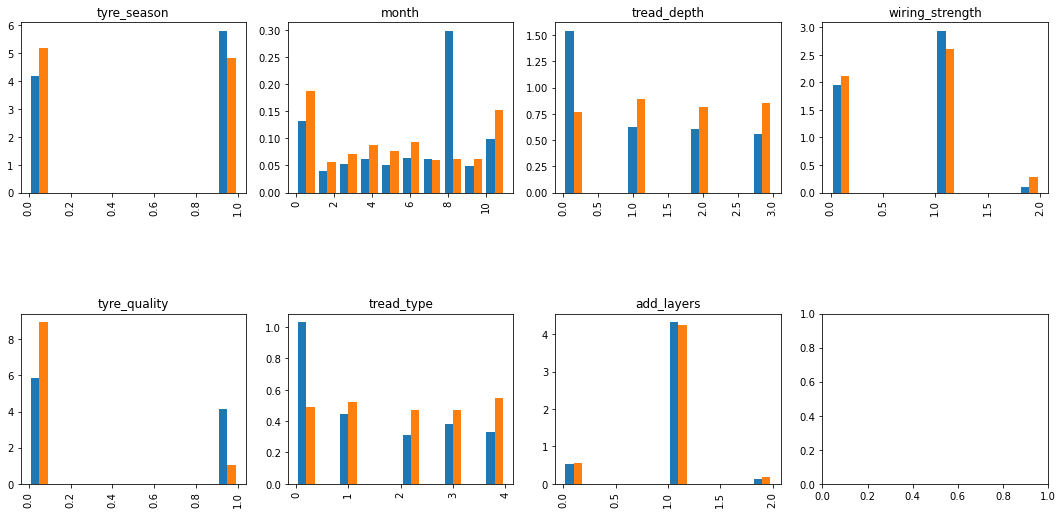

In [87]:
df_0=cat[df['failure']==0] # records wih target==0
df_1=cat[df['failure']==1] # records wih target==1


fig, axes = plt.subplots(2, 4,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)
i=0
for x in cat.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([df_0[x],df_1[x]],density=True)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    i+=1
plt.show()

#blue --> test was succesfull 
#orange --> tast was not suf